# Working on self-drive car sentiments

Implementing LSTM for two classes i.e Benefit vs Risk

In [0]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


In [3]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
# For evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [5]:
import pickle
#Loading from firm cleaned file
df = pd.read_pickle('sentiment_self_drive.pkl')
df.shape

(6943, 2)

In [6]:
df.head()

,text,sent_numeric
0,Two places I'd invest all my money if I could:...,Beneficial
1,Awesome! Google driverless cars will help the ...,Beneficial
2,If Google maps can't keep up with road constru...,Risky
3,Autonomous cars seem way overhyped given the t...,Risky
4,Just saw Google self-driving car on I-34. It w...,Neutral


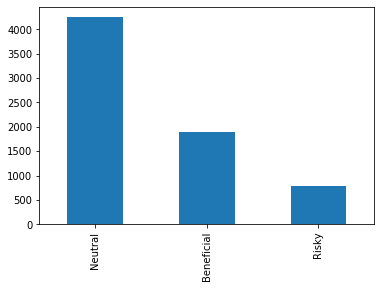

In [7]:
df.sent_numeric.value_counts().plot(kind='bar')

## Using only positive and negative sentiments

In [0]:
df=df[df.sent_numeric!= "Neutral"]

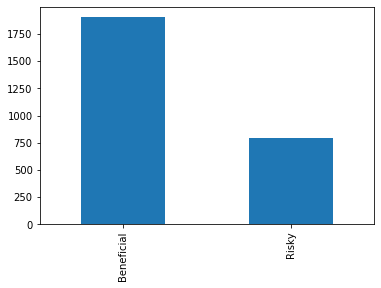

In [9]:
df.sent_numeric.value_counts().plot(kind='bar')

In [10]:
df.sent_numeric.value_counts()

Beneficial    1903
Risky          795
Name: sent_numeric, dtype: int64

In [11]:
df.sent_numeric.value_counts(normalize=True)

Beneficial    0.705337
Risky         0.294663
Name: sent_numeric, dtype: float64

In [12]:
df.shape

(2698, 2)

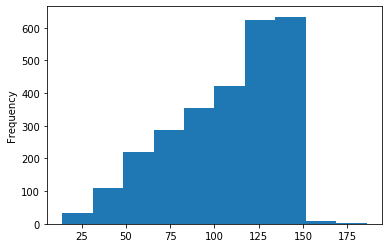

In [13]:
df['text'].str.len().plot.hist()

# Text Cleaning

In [0]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;#]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z +_]')
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['rt', 'http']) # extend stopwords; rt means re-tweet
STOPWORDS = set(STOPWORDS)

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
    text = text.strip()
    return text

In [0]:
df['cleaned']=[text_prepare(x) for x in df['text']]

In [16]:
print(df.text[0])

Two places I'd invest all my money if I could: 3D printing and Self-driving cars!!!


In [17]:
df.cleaned[0]

'two places id invest money could 3d printing selfdriving cars'

### most common words

In [18]:
# Dictionary of all words from train corpus with their counts.
words_counts = {}

from collections import Counter
words_counts = Counter([word for line in df['cleaned'] for word in line.split(' ')])

# Sorting 
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Top 10
most_common_words[:10]

[('car', 1367),
 ('cars', 1345),
 ('tco', 1090),
 ('selfdriving', 1004),
 ('google', 928),
 ('driving', 804),
 ('driverless', 713),
 ('self', 670),
 ('googles', 243),
 ('cant', 155)]

### Splitting data
Split X and y into training and testing sets

In [0]:
X=df['cleaned']
y=df['sent_numeric']

In [20]:
print(X.shape)
print(y.shape)

(2698,)
(2698,)


### Step1- Convert words to matrix
We need to convert words into matrices. One way is shown through sklearn. Other way is given. We can always match the two

### i-I started by fitting a tokenizer on my document as in here:

In [0]:
# Fitting
max_fatures = 5000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 280
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(X)

In [22]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 7332 unique tokens.


### ii- I wanted to check if my data is fitted correctly so I converted into sequence

In [0]:
# convert to sequence
X_token = tokenizer.texts_to_sequences(X)

In [24]:
pd.DataFrame(X_token).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,126,461,90.0,819.0,210.0,22.0,505.0,820.0,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,45,5,7.0,2.0,252.0,302.0,462.0,1042.0,93.0,3.0,2253.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,171,10.0,272.0,37.0,1043.0,1044.0,99.0,7.0,1.0,17.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19,2,506.0,30.0,1407.0,573.0,46.0,675.0,676.0,574.0,506.0,53.0,1408.0,273.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19,58,22.0,274.0,39.0,1409.0,2254.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### pad_sequence

To keep all vectors of same length, I will use pad_sequence

In [0]:
X_pd_sq = pad_sequences(X_token,maxlen=MAX_SEQUENCE_LENGTH)

In [26]:
print('Shape of data tensor:', X_pd_sq.shape)

Shape of data tensor: (2698, 280)


To avoid AttributeError: 'numpy.ndarray' object has no attribute 'head', we will check in dataframe. Still input to neural network will be numpy array not dataframe

In [27]:
pd.DataFrame(X_pd_sq).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,126,461,90,819,210,22,505,820,4,2
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,5,7,2,252,302,462,1042,93,3,2253
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,171,10,272,37,1043,1044,99,7,1,17,63
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,2,506,30,1407,573,46,675,676,574,506,53,1408,273
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,58,22,274,39,1409,2254


##Step 2- Train-test split

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pd_sq, y, random_state=2019)

In [30]:
X_train.shape, X_test.shape

((2023, 280), (675, 280))

In [31]:
print(y_train.shape)
print(y_test.shape)

(2023,)
(675,)


## Step 3- Encoding y-labeled feature

this step is very important as we need to decode categorical variables into dummy

In [0]:
# keras needs inputs to be vectors , so one hot encoding values
from keras.utils import np_utils
def one_hot_encode_object_array(arr):
    '''One hot encode a numpy array of objects (e.g. strings)'''
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))

y_train_ohe=one_hot_encode_object_array(y_train)
y_test_ohe=one_hot_encode_object_array(y_test)

In [33]:
y_train[:5]

5487    Beneficial
6047    Beneficial
3494    Beneficial
1195         Risky
1394    Beneficial
Name: sent_numeric, dtype: object

In [34]:
y_train_ohe[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

- **So, 1,0 is benficial and 0,1 is risky**

In [35]:
print(y_train_ohe.shape)
print(y_test_ohe.shape)

(2023, 2)
(675, 2)


In [38]:
unique_y_labels = list(y_train.value_counts().index)
unique_y_labels

['Beneficial', 'Risky']

In [39]:
len(unique_y_labels)

2

# Create LSTM model

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils

In [0]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
# Max number of words in each tweet.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
# for our padding seq
input_length=X_pd_sq.shape[1]
uniq_y_label=len(unique_y_labels)

In [41]:
X_pd_sq.shape[1]

280

### Build model

In [44]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length = X_pd_sq.shape[1]))
# X_pd_sq.shape[1] refers to 280 columns 
model.add(SpatialDropout1D(0.4))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 280, 100)          500000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 280, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 580,602
Trainable params: 580,602
Non-trainable params: 0
_________________________________________________________________
None


### Train model

In [0]:
batch_size = 64
epochs = 15

In [0]:
from keras.callbacks import EarlyStopping

In [47]:
history = model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])




Train on 1820 samples, validate on 203 samples
Epoch 1/15





1820/1820 [==============================] - 26s 14ms/step - loss: 0.6250 - acc: 0.7055 - val_loss: 0.6074 - val_acc: 0.6946
Epoch 2/15
1820/1820 [==============================] - 16s 9ms/step - loss: 0.5754 - acc: 0.7082 - val_loss: 0.5872 - val_acc: 0.6946
Epoch 3/15
1820/1820 [==============================] - 16s 9ms/step - loss: 0.4799 - acc: 0.7560 - val_loss: 0.5159 - val_acc: 0.7094
Epoch 4/15
1820/1820 [==============================] - 16s 9ms/step - loss: 0.2893 - acc: 0.8940 - val_loss: 0.5181 - val_acc: 0.7586
Epoch 5/15
1820/1820 [==============================] - 16s 9ms/step - loss: 0.1842 - acc: 0.9346 - val_loss: 0.6191 - val_acc: 0.7537
Epoch 6/15
1820/1820 [==============================] - 16s 9ms/step - loss: 0.1404 - acc: 0.9549 - val_loss: 0.6218 - val_acc: 0.7537


In [57]:
accr = model.evaluate(X_test,y_test_ohe)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

675/675 [==============================] - 4s 6ms/step
Test set
  Loss: 0.636
  Accuracy: 0.729


# Model Evaluation

In [0]:
# predict probabilities for test set
y_pred = model.predict(X_test)

In [49]:
y_pred[:5]

array([[2.7158627e-01, 7.2841376e-01],
       [9.9902642e-01, 9.7363850e-04],
       [7.5415713e-01, 2.4584290e-01],
       [2.4125619e-01, 7.5874382e-01],
       [9.6236497e-01, 3.7635084e-02]], dtype=float32)

**This is probabilities of our output. We need to convert to crisp classes.**

In [0]:
# predict crisp classes for test set. Output will be 1-D
yhat_classes = model.predict_classes(X_test, verbose=0)

In [51]:
yhat_classes[:5]

array([1, 0, 0, 1, 0])

In [52]:
y_test_ohe[:5]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [0]:
#Other way to do it
y_test_class = np.argmax(y_test_ohe,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

In [54]:
y_test_class[:5]

array([0, 0, 1, 0, 0])

In [55]:
y_pred_class[:5]

array([1, 0, 0, 1, 0])

### Classification Report

In [56]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       473
           1       0.55      0.51      0.53       202

    accuracy                           0.73       675
   macro avg       0.67      0.67      0.67       675
weighted avg       0.72      0.73      0.73       675



## Confusion Matrix

In [60]:
y_test.value_counts()

Beneficial    473
Risky         202
Name: sent_numeric, dtype: int64

In [58]:
print(confusion_matrix(y_test_class,y_pred_class))

[[388  85]
 [ 98 104]]


In [61]:
! pip install scikit-plot

<Figure size 720x720 with 0 Axes>

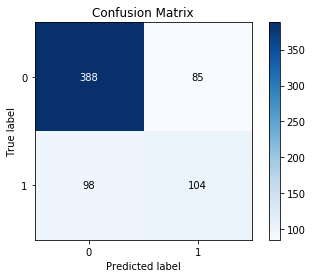

In [62]:
import scikitplot as skplt
plt.figure(figsize=(10,10))
skplt.metrics.plot_confusion_matrix(y_test_class,y_pred_class)
plt.show()

In [63]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_norm)

[[0.82029598 0.17970402]
 [0.48514851 0.51485149]]


<Figure size 720x720 with 0 Axes>

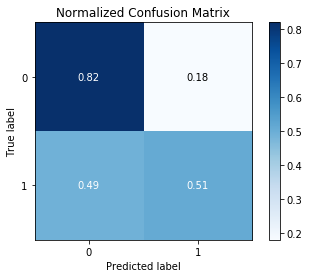

In [64]:
plt.figure(figsize=(10,10))
skplt.metrics.plot_confusion_matrix(y_test_class,y_pred_class, normalize=True)
plt.show()

## Accuracy and loss function

In [65]:
# For test set
loss, accuracy = model.evaluate(X_test, y_test_ohe, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Loss:  {:.4f}".format(loss))

Testing Accuracy:  0.7289
Testing Loss:  0.6364


In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

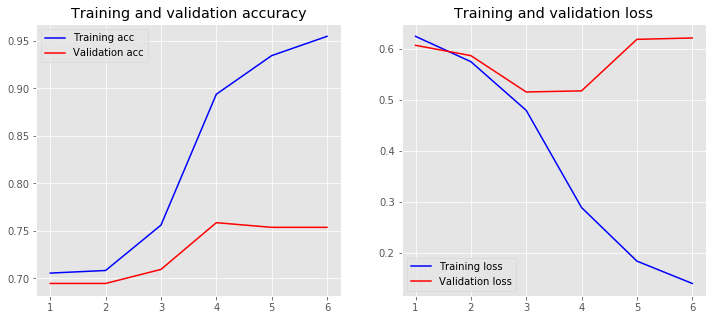

In [67]:
plot_history(history)